In [80]:
import pandas
import os
import matplotlib.pyplot as plt

In [81]:
#path = r'/Users/dorotheeduvaux 1/UCL CSML/MSc Project'
path = '/Users/dorotheeduvaux/PycharmProjects/SurgicalWorkflowProject/raw_data'
filename = 'data_steps.csv'
raw_dataset_df = pandas.read_csv(os.path.join(path, filename))
#PATH_FOR_SAVING = r'/Users/dorotheeduvaux 1/UCL CSML/MSc Project/Video analytics'
PATH_FOR_SAVING = '/Users/dorotheeduvaux/PycharmProjects/SurgicalWorkflowProject/raw_data'

In [3]:
phase_step_map = {
    'tumour_debulking':1,
    'dissection_medial':1,
    'dissection_inferior':1,
    'dissection_superior':1,
    'dissection_lateral':1,
    'idle_time':'p0',
    'rs_approach_and_exposure':0,
    'rs_tumour_debunking_and_excision': 1,
    'rs_closure': 2,
}

### Creating the phase dataset

In [4]:
# removing rows that have duplicate time stamps and cause issues
raw_dataset_df = raw_dataset_df[~raw_dataset_df['step'].isin(['Cystic component opened',
                                                              'Idle time as drilling?', 
                                                              'Drill is being used - Idle time as no label'])]
index_to_exclude1 = raw_dataset_df.loc[(raw_dataset_df['number']==8) 
                   & (raw_dataset_df['step']=='dissection_lateral') 
                   & (raw_dataset_df['timestamp']=='04:34:22')
                  ].index
index_to_exclude2 = raw_dataset_df.loc[(raw_dataset_df['number']==25) 
                   & (raw_dataset_df['step']=='Cannot see surgical field') 
                   & (raw_dataset_df['timestamp']=='03:30:31')
                  ].index
raw_dataset_df = raw_dataset_df.drop(index_to_exclude1) 
raw_dataset_df = raw_dataset_df.drop(index_to_exclude2) 
raw_dataset_df

,approach,number,step,timestamp
0,RS,1,rs_approach_and_exposure,00:00:04
1,RS,1,rs_tumour_debunking_and_excision,00:02:38
2,RS,1,tumour_debulking,00:03:09
3,RS,1,idle_time,00:04:44
4,RS,1,tumour_debulking,00:05:44
...,...,...,...,...
2657,RS,9,idle_time,05:12:51
2658,RS,9,tumour_debulking,05:16:13
2659,RS,9,rs_closure,05:16:18
2660,RS,9,idle_time,05:27:57


In [5]:
df = raw_dataset_df.copy()
df['step_number'] = df['step'].map(phase_step_map).fillna("other") 
df['timestamp'] = pandas.to_datetime(df['timestamp'])
video_nums = df['number'].drop_duplicates().values
#df.to_csv('/')

/var/folders/_x/qj3jqz3111x0t0l3nqdb9k6r0000gp/T/ipykernel_25172/1000432329.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pandas.to_datetime(df['timestamp'])


In [6]:
def adjust_frame_folder_string(value, item):
    path = r'/Users/dorotheeduvaux 1/UCL CSML/MSc Project'
    video_num = '0' + str(item) if item < 10 else str(item) 
    overall_path = os.path.join(path, 'RS_data/video_outputs', str(item), f'video{video_num}_{value}.png')
    return overall_path

In [7]:
#### Take in the total timestamp of each video and construct a frame column
overall_total_timestamp = {
    1:  '06:14:19',
    4:  '05:54:02',
    6:  '06:49:20',
    7:  '06:40:15',
    8:  '05:17:33',
    9:  '05:37:32',
    11: '03:01:30',
    12: '03:16:10',
    13: '02:32:50',
    14: '04:58:50',
    15: '01:24:16',
    16: '03:41:07',
    17: '06:01:18',
    20: '05:33:36',
    21: '05:24:28',
    22: '06:11:55',
    23: '01:58:34',
    24: '06:52:36',
    25: '05:08:07',
    26: '04:47:45',
    27: '03:21:16',
}

In [67]:
pandas_lists = []
import pprint
for item in video_nums:
    try:
        data = df[df['number'] == item]
        data = data.sort_values('timestamp').reset_index().drop(columns='index')
        final_timestamp = overall_total_timestamp[item]
        # data = data.append({'approach':'RS','number': video_num, 'step':'end', 'timestamp': final_timestamp, 'step_number':2}, ignore_index=True)
        data.loc[len(data)] = {'approach':'RS', 'number': item, 'step':'rs_closure', 'timestamp': pandas.to_datetime(final_timestamp), 'step_number':2}
        
        # sample at 1 frame every 25 seconds
        data = data.set_index('timestamp')
        data = data[~data.index.duplicated()]
        data = data.resample('25s').ffill()
        # Check if the last index value is not the same as final_timestamp
        if data.index[-1] != final_timestamp:
            # Update the last index value to be final_timestamp
            # This creates a new DataFrame with the updated index
            new_index = data.index[:-1].append(pandas.Index([pandas.to_datetime(final_timestamp)]))
            data = data.reindex(new_index)
            data.loc[data.index[-1]] = {'approach':'RS', 'number': item, 'step':'rs_closure', 'step_number':2}
        if data.index[0] == pandas.to_datetime('00:00:00'):
            data.loc[data.index[0]] = {'approach':'RS', 'number': item, 'step':'rs_approach_and_exposure', 'step_number':0}
        data.index.name = 'timestamp'
        
        # # map extracted frames at 5fps to the 1fps dataframe
        time_data = pandas.DataFrame({'timestamp': [pandas.to_datetime('00:00:00'), 
                                       pandas.to_datetime(overall_total_timestamp[item])]})
        time_data = time_data.set_index('timestamp')
        time_data = time_data.resample('200ms').ffill()
        time_data['frame_number'] = [str(i).zfill(6) for i in range(1, len(time_data)+1)]
        time_data['frame_number'] = time_data['frame_number'].apply(adjust_frame_folder_string, args=(item,))
        
        # # Join on the file location
        data = pandas.merge(data, time_data, on='timestamp', how='left')
        
        # restrict to the steps that we are interested in + formatting
        data = data[data['step_number'].isin([0,1,2])].reset_index()
        data['timestamp'] = data['timestamp'].dt.time
        
        pandas_lists.append(data)
    except Exception as e:
        print(f"Problem with video {item}: ", e)
    
result = pandas.concat(pandas_lists)
result.to_csv(os.path.join(PATH_FOR_SAVING, 'reduced_coarse_phase_frames_data.csv'), index=False)

### Amending reduced_phase_frames_data.csv

In [68]:
df = pandas.read_csv(os.path.join(PATH_FOR_SAVING, 'reduced_coarse_phase_frames_data.csv'))
indices_to_remove = []
for index, row in df.iterrows():
    if not os.path.exists(row[5]):
        indices_to_remove.append(index)
        print(row[5])

/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_112296.png
/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/13/video13_045851.png
/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/14/video14_089651.png
/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/16/video16_066336.png
/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/17/video17_108391.png
/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/21/video21_097341.png
/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/22/video22_111576.png
/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/23/video23_035571.png
/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/25/video25_092436.png
/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/26/video26_086326.png
/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/27/video27_060381.png
/Users/dorotheeduvaux 

In [73]:
mod_df = df[~df.index.isin(indices_to_remove)]
mod_df.to_csv(os.path.join(PATH_FOR_SAVING, 'mod_coarse_reduced_phase_frames_data.csv'), index=False)
print(len(df), len(mod_df), len(indices_to_remove))

11446 11432 14


,timestamp,approach,number,step,step_number,frame_number
0,00:00:00,RS,9.0,rs_approach_and_exposure,0,/Users/dorotheeduvaux 1/UCL CSML/MSc Project/R...
1,00:00:25,RS,9.0,rs_approach_and_exposure,0,/Users/dorotheeduvaux 1/UCL CSML/MSc Project/R...
2,00:00:50,RS,9.0,rs_approach_and_exposure,0,/Users/dorotheeduvaux 1/UCL CSML/MSc Project/R...
3,00:01:15,RS,9.0,rs_approach_and_exposure,0,/Users/dorotheeduvaux 1/UCL CSML/MSc Project/R...
4,00:01:40,RS,9.0,rs_approach_and_exposure,0,/Users/dorotheeduvaux 1/UCL CSML/MSc Project/R...
...,...,...,...,...,...,...
616,05:26:40,RS,9.0,rs_closure,2,/Users/dorotheeduvaux 1/UCL CSML/MSc Project/R...
617,05:27:05,RS,9.0,rs_closure,2,/Users/dorotheeduvaux 1/UCL CSML/MSc Project/R...
618,05:27:30,RS,9.0,rs_closure,2,/Users/dorotheeduvaux 1/UCL CSML/MSc Project/R...
619,05:27:55,RS,9.0,rs_closure,2,/Users/dorotheeduvaux 1/UCL CSML/MSc Project/R...


### Creating a pkl file


In [72]:
#frames = pandas.read_csv(os.path.join(PATH_FOR_SAVING, 'reduced_phase_frames_data.csv'))
frames = pandas.read_csv(os.path.join(PATH_FOR_SAVING, 'mod_coarse_reduced_phase_frames_data.csv'))
def modify_frame_name(value):
    new_value = value.replace('/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs',
                              '/home/dorothee/RS_data/final_frames')
    return new_value
frames['frame_number'] = frames['frame_number'].apply(modify_frame_name)
video_nums = frames['number'].drop_duplicates().values
frames

,timestamp,approach,number,step,step_number,frame_number
0,00:00:00,RS,1.0,rs_approach_and_exposure,0,/home/dorothee/RS_data/final_frames/1/video01_...
1,00:00:25,RS,1.0,rs_approach_and_exposure,0,/home/dorothee/RS_data/final_frames/1/video01_...
2,00:00:50,RS,1.0,rs_approach_and_exposure,0,/home/dorothee/RS_data/final_frames/1/video01_...
3,00:01:15,RS,1.0,rs_approach_and_exposure,0,/home/dorothee/RS_data/final_frames/1/video01_...
4,00:01:40,RS,1.0,rs_approach_and_exposure,0,/home/dorothee/RS_data/final_frames/1/video01_...
...,...,...,...,...,...,...
11427,05:26:40,RS,9.0,rs_closure,2,/home/dorothee/RS_data/final_frames/9/video09_...
11428,05:27:05,RS,9.0,rs_closure,2,/home/dorothee/RS_data/final_frames/9/video09_...
11429,05:27:30,RS,9.0,rs_closure,2,/home/dorothee/RS_data/final_frames/9/video09_...
11430,05:27:55,RS,9.0,rs_closure,2,/home/dorothee/RS_data/final_frames/9/video09_...


In [74]:
## Option 1 (17/4)
import pickle 

# TODO: amend the path name if I'm running on the server

train_num = []
train_paths = []
train_labels = []
test_num = []
test_paths = []
test_labels = []
val_num = []
val_paths = []
val_labels = []

validation_dataset = [6, 20, 25, 27]
test_dataset = [6, 20, 25, 27]
total_testing_dataset = list(set(validation_dataset + test_dataset))
training_dataset = [video for video in video_nums if video not in total_testing_dataset]

for video in video_nums:
    data = frames[frames['number']==video]
    if video in training_dataset:
        train_num.append(len(data))
        train_paths.extend(data['frame_number'].values)
        train_labels.extend(data['step_number'].values)
    if video in validation_dataset:
        val_num.append(len(data))
        val_paths.extend(data['frame_number'].values)
        val_labels.extend(data['step_number'].values)
    if video in test_dataset:
        test_num.append(len(data))
        test_paths.extend(data['frame_number'].values)
        test_labels.extend(data['step_number'].values)

train_val_test_paths_labels = []
train_val_test_paths_labels.append(train_paths)
train_val_test_paths_labels.append(val_paths)

train_val_test_paths_labels.append(train_labels)
train_val_test_paths_labels.append(val_labels)

train_val_test_paths_labels.append(train_num)
train_val_test_paths_labels.append(val_num)

train_val_test_paths_labels.append(test_paths)
train_val_test_paths_labels.append(test_labels)
train_val_test_paths_labels.append(test_num)

with open(os.path.join(PATH_FOR_SAVING,'server_train_val_paths_coarse_phases_labels.pkl'), 'wb') as f:
    pickle.dump(train_val_test_paths_labels, f)

### Fold 2

In [75]:
# Fold 2:(1, 9, 12, 23)
# Fold 3: (7, 13, 16, 21)
# Fold 4: (4, 8, 15, 24)
# Fold 5: (11, 14, 17, 22, 26)

import pickle 

train_num = []
train_paths = []
train_labels = []
test_num = []
test_paths = []
test_labels = []
val_num = []
val_paths = []
val_labels = []

validation_dataset = [1, 9, 12, 23]
test_dataset = [1, 9, 12, 23]
total_testing_dataset = list(set(validation_dataset + test_dataset))
training_dataset = [video for video in video_nums if video not in total_testing_dataset]

for video in video_nums:
    data = frames[frames['number']==video]
    if video in training_dataset:
        train_num.append(len(data))
        train_paths.extend(data['frame_number'].values)
        train_labels.extend(data['step_number'].values)
    if video in validation_dataset:
        val_num.append(len(data))
        val_paths.extend(data['frame_number'].values)
        val_labels.extend(data['step_number'].values)
    if video in test_dataset:
        test_num.append(len(data))
        test_paths.extend(data['frame_number'].values)
        test_labels.extend(data['step_number'].values)

train_val_test_paths_labels = []
train_val_test_paths_labels.append(train_paths)
train_val_test_paths_labels.append(val_paths)

train_val_test_paths_labels.append(train_labels)
train_val_test_paths_labels.append(val_labels)

train_val_test_paths_labels.append(train_num)
train_val_test_paths_labels.append(val_num)

train_val_test_paths_labels.append(test_paths)
train_val_test_paths_labels.append(test_labels)
train_val_test_paths_labels.append(test_num)

with open(os.path.join(PATH_FOR_SAVING,'server_train_val_paths_coarse_phases_labels_fold2.pkl'), 'wb') as f:
    pickle.dump(train_val_test_paths_labels, f)

### Fold 3

In [76]:
# Fold 3: (7, 13, 16, 21)
# Fold 4: (4, 8, 15, 24)
# Fold 5: (11, 14, 17, 22, 26)

import pickle 

train_num = []
train_paths = []
train_labels = []
test_num = []
test_paths = []
test_labels = []
val_num = []
val_paths = []
val_labels = []

validation_dataset = [7, 13, 16, 21]
test_dataset = [7, 13, 16, 21]
total_testing_dataset = list(set(validation_dataset + test_dataset))
training_dataset = [video for video in video_nums if video not in total_testing_dataset]

for video in video_nums:
    data = frames[frames['number']==video]
    if video in training_dataset:
        train_num.append(len(data))
        train_paths.extend(data['frame_number'].values)
        train_labels.extend(data['step_number'].values)
    if video in validation_dataset:
        val_num.append(len(data))
        val_paths.extend(data['frame_number'].values)
        val_labels.extend(data['step_number'].values)
    if video in test_dataset:
        test_num.append(len(data))
        test_paths.extend(data['frame_number'].values)
        test_labels.extend(data['step_number'].values)

train_val_test_paths_labels = []
train_val_test_paths_labels.append(train_paths)
train_val_test_paths_labels.append(val_paths)

train_val_test_paths_labels.append(train_labels)
train_val_test_paths_labels.append(val_labels)

train_val_test_paths_labels.append(train_num)
train_val_test_paths_labels.append(val_num)

train_val_test_paths_labels.append(test_paths)
train_val_test_paths_labels.append(test_labels)
train_val_test_paths_labels.append(test_num)

with open(os.path.join(PATH_FOR_SAVING,'server_train_val_paths_coarse_phases_labels_fold3.pkl'), 'wb') as f:
    pickle.dump(train_val_test_paths_labels, f)

### Fold 4

In [77]:
# Fold 3: (7, 13, 16, 21)
# Fold 4: (4, 8, 15, 24)
# Fold 5: (11, 14, 17, 22, 26)

import pickle 

train_num = []
train_paths = []
train_labels = []
test_num = []
test_paths = []
test_labels = []
val_num = []
val_paths = []
val_labels = []

validation_dataset = [4, 8, 15, 24]
test_dataset = [4, 8, 15, 24]
total_testing_dataset = list(set(validation_dataset + test_dataset))
training_dataset = [video for video in video_nums if video not in total_testing_dataset]

for video in video_nums:
    data = frames[frames['number']==video]
    if video in training_dataset:
        train_num.append(len(data))
        train_paths.extend(data['frame_number'].values)
        train_labels.extend(data['step_number'].values)
    if video in validation_dataset:
        val_num.append(len(data))
        val_paths.extend(data['frame_number'].values)
        val_labels.extend(data['step_number'].values)
    if video in test_dataset:
        test_num.append(len(data))
        test_paths.extend(data['frame_number'].values)
        test_labels.extend(data['step_number'].values)

train_val_test_paths_labels = []
train_val_test_paths_labels.append(train_paths)
train_val_test_paths_labels.append(val_paths)

train_val_test_paths_labels.append(train_labels)
train_val_test_paths_labels.append(val_labels)

train_val_test_paths_labels.append(train_num)
train_val_test_paths_labels.append(val_num)

train_val_test_paths_labels.append(test_paths)
train_val_test_paths_labels.append(test_labels)
train_val_test_paths_labels.append(test_num)

with open(os.path.join(PATH_FOR_SAVING,'server_train_val_paths_coarse_phases_labels_fold4.pkl'), 'wb') as f:
    pickle.dump(train_val_test_paths_labels, f)

### Fold5

In [78]:
# Fold 5: (11, 14, 17, 22, 26)

import pickle 

train_num = []
train_paths = []
train_labels = []
test_num = []
test_paths = []
test_labels = []
val_num = []
val_paths = []
val_labels = []

validation_dataset = [11, 14, 17, 22, 26]
test_dataset = [11, 14, 17, 22, 26]
total_testing_dataset = list(set(validation_dataset + test_dataset))
training_dataset = [video for video in video_nums if video not in total_testing_dataset]

for video in video_nums:
    data = frames[frames['number']==video]
    if video in training_dataset:
        train_num.append(len(data))
        train_paths.extend(data['frame_number'].values)
        train_labels.extend(data['step_number'].values)
    if video in validation_dataset:
        val_num.append(len(data))
        val_paths.extend(data['frame_number'].values)
        val_labels.extend(data['step_number'].values)
    if video in test_dataset:
        test_num.append(len(data))
        test_paths.extend(data['frame_number'].values)
        test_labels.extend(data['step_number'].values)

train_val_test_paths_labels = []
train_val_test_paths_labels.append(train_paths)
train_val_test_paths_labels.append(val_paths)

train_val_test_paths_labels.append(train_labels)
train_val_test_paths_labels.append(val_labels)

train_val_test_paths_labels.append(train_num)
train_val_test_paths_labels.append(val_num)

train_val_test_paths_labels.append(test_paths)
train_val_test_paths_labels.append(test_labels)
train_val_test_paths_labels.append(test_num)

with open(os.path.join(PATH_FOR_SAVING,'server_train_val_paths_coarse_phases_labels_fold5.pkl'), 'wb') as f:
    pickle.dump(train_val_test_paths_labels, f)

### Moving the required files

In [87]:
import shutil
import os
from pathlib import Path
import pandas

In [100]:
results = pandas.read_csv(os.path.join(PATH_FOR_SAVING, 'reduced_coarse_phase_frames_data.csv'))
files = results['frame_number'].values
results[results['number']==1.0]['frame_number'].to_list()

['/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000001.png',
 '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000126.png',
 '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000251.png',
 '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000376.png',
 '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000501.png',
 '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000626.png',
 '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000751.png',
 '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_000876.png',
 '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_001001.png',
 '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_001126.png',
 '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_0

In [101]:
files = results['frame_number'].values
for file in files:
    existing_file_location = Path(str(Path(file)).replace('video_outputs','final_frames'
                                          ).replace('/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data',
                                     '/Volumes/Seagate/RS data/'))
    destination_file_location = Path(str(Path(file)).replace('video_outputs','final_coarse_phase_frames'
                                          ).replace('/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data',
                                     '/Volumes/Seagate/RS data/'))
    dest_parent_folder = Path(str(Path(destination_file_location).parent))
    if not os.path.exists(dest_parent_folder):
        os.makedirs(dest_parent_folder)
    if not os.path.exists(existing_file_location):
        try:
            shutil.copy(file, destination_file_location)
        except Exception as e:
            print(e)

[Errno 2] No such file or directory: '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/1/video01_112296.png'
[Errno 2] No such file or directory: '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/13/video13_045851.png'
[Errno 2] No such file or directory: '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/14/video14_089651.png'
[Errno 2] No such file or directory: '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/16/video16_066336.png'
[Errno 2] No such file or directory: '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/17/video17_108391.png'
[Errno 2] No such file or directory: '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/21/video21_097341.png'
[Errno 2] No such file or directory: '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/22/video22_111576.png'
[Errno 2] No such file or directory: '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/video_outputs/

### Transferring over frames from final_phase_frames to final_frames
##### In case there are any frames in final_frames that are not in final_phase_frames

In [79]:
final_frames_folder = Path('/Users/dorotheeduvaux 1/UCL CSML/MSc Project/RS_data/final_frames')
phase_frames_folder = Path('/Volumes/Seagate/RS data/final_frames')

folders = [item for item in os.listdir(phase_frames_folder) if item not in['.DS_Store','dummy_dataset']]
print(folders)



NameError: name 'Path' is not defined

In [143]:

for folder in folders:
    phase_files = os.listdir(os.path.join(phase_frames_folder, folder))
    final_frames_files = os.listdir(os.path.join(final_frames_folder, folder))
    for file in final_frames_files:
        if file not in phase_files:
            # print(os.path.join(phase_frames_folder, folder, file))
            # print(os.path.join(final_frames_folder, folder, file))
            shutil.copy(os.path.join(final_frames_folder, folder, file), os.path.join(phase_frames_folder, folder, file))

#### Visualisations

In [144]:
overall_total_timestamp = {
    1:  '06:14:19',
    4:  '05:54:02',
    6:  '06:49:20',
    7:  '06:40:15',
    8:  '05:17:33',
    9:  '05:37:32',
    11: '03:01:30',
    12: '03:16:10',
    13: '02:32:50',
    14: '04:58:50',
    15: '01:24:16',
    16: '03:41:07',
    17: '06:01:18',
    20: '05:33:36',
    21: '05:24:28',
    22: '06:11:55',
    23: '01:58:34',
    24: '06:52:36',
    25: '05:08:07',
    26: '04:47:45',
    27: '03:21:16',
}


adj_step_map = { 
    'tumour_debulking': 0,
    'dissection_medial': 1,
    'dissection_inferior': 2,
    'dissection_superior': 3, 
    'dissection_lateral': 4,
    'end': 'end',
}

colors = {
    0: 'blue', # tumour debulking
    1: 'green', # dissection medial
    2: 'red', # dissection inferior
    3: 'skyblue', # dissection superior
    4: 'orange', # dissection lateral
    'other': 'gray',
    'end': 'gray',
}


phase_step_map = {
    'rs_approach_and_exposure': 0,
    'rs_tumour_debunking_and_excision': 1,
    'tumour_debulking': 1,
    'dissection_medial': 1,
    'dissection_inferior': 1,
    'dissection_superior': 1,
    'rs_closure': 2,
    'dissection_lateral': 1,
}

combined_step_map = {
    # 'rs_approach_and_exposure': ,
    # 'rs_tumour_debunking_and_excision':,
    'tumour_debulking':0,
    'dissection_medial':1,
    'dissection_inferior':1,
    'dissection_superior':1,
    # 'rs_closure':,
    'dissection_lateral':1,
}


In [149]:
import pandas
import os
import numpy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

path = r'/Users/dorotheeduvaux 1/UCL CSML/MSc Project'
input_file = os.path.join(path, 'data_steps.csv')
df = pandas.read_csv(input_file)
video_nums = df['number'].drop_duplicates()


/var/folders/_x/qj3jqz3111x0t0l3nqdb9k6r0000gp/T/ipykernel_75750/2653965294.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[len(data)] = {'approach':'RS','number': video_num, 'step':'end', 'timestamp': final_timestamp}
/var/folders/_x/qj3jqz3111x0t0l3nqdb9k6r0000gp/T/ipykernel_75750/2653965294.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['diff'] = pandas.to_datetime(data['timestamp'].shift(-1), format='%H:%M:%S') - pandas.to_datetime(data['timestamp'], format='%H:%M:%S')
/var/folders/_x/qj3jqz3111x0t0l3nqdb9k6r0000gp/T/ipykernel_75750/265

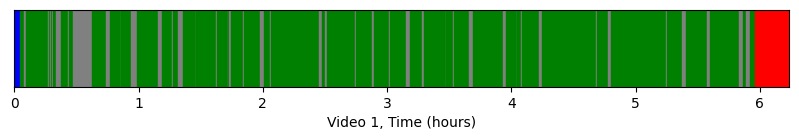

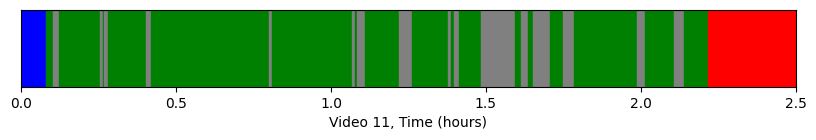

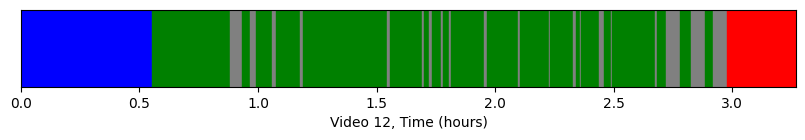

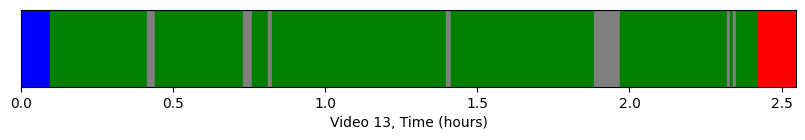

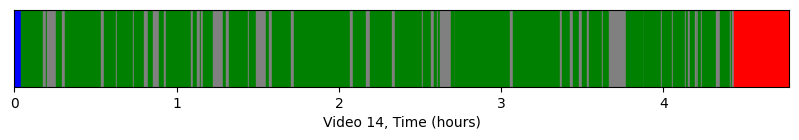

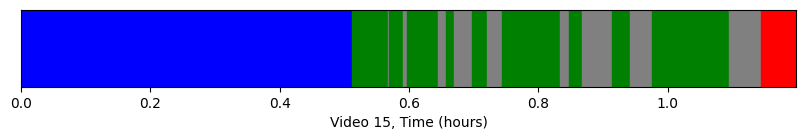

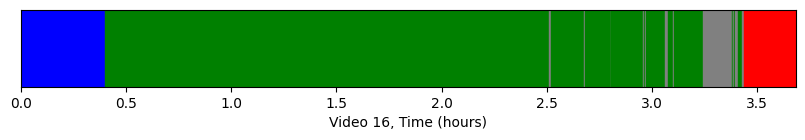

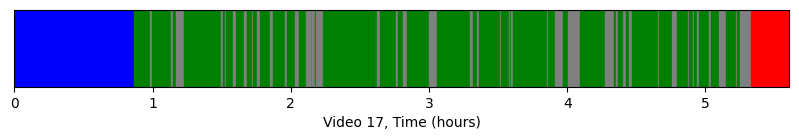

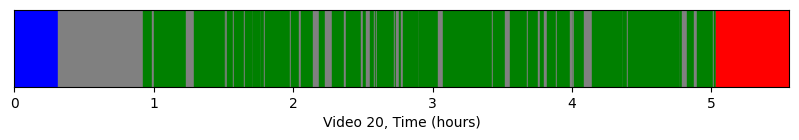

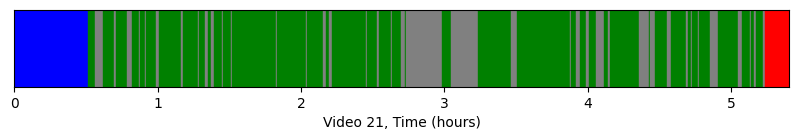

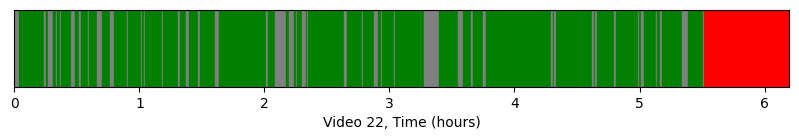

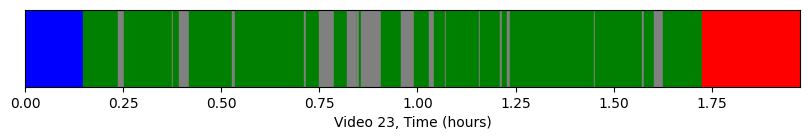

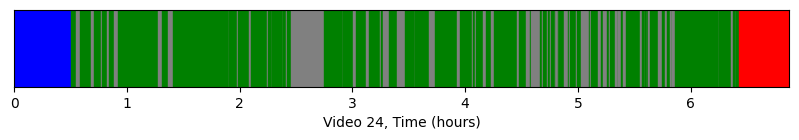

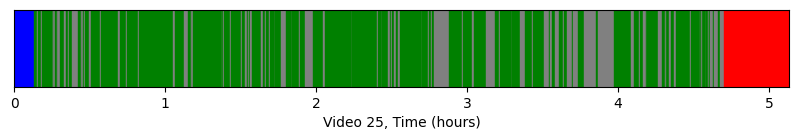

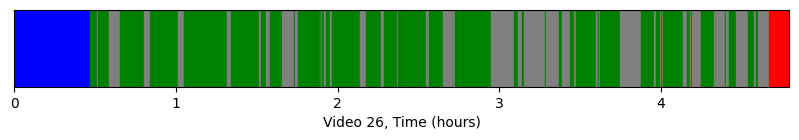

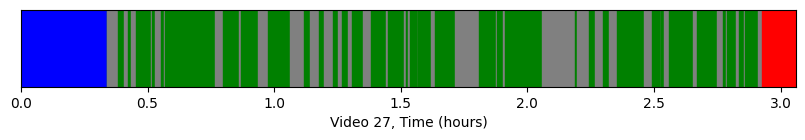

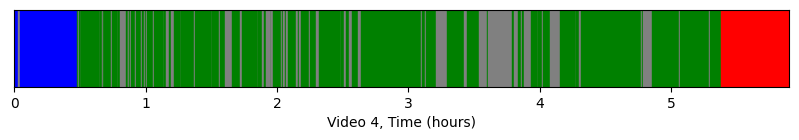

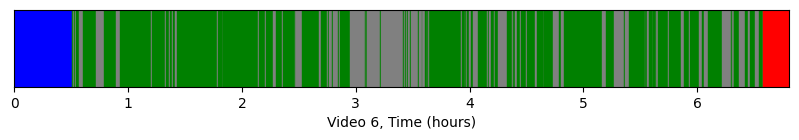

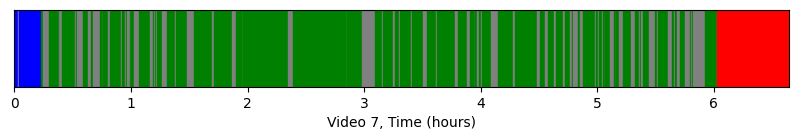

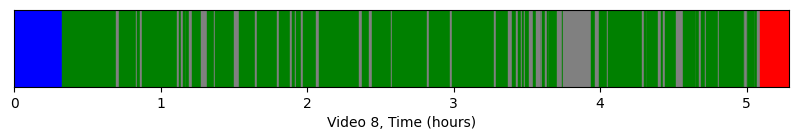

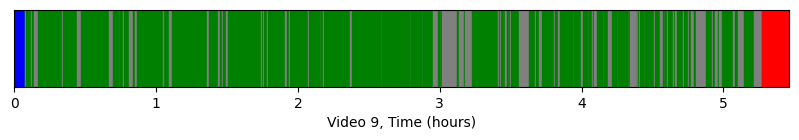

In [151]:
for video_num in video_nums:

    data = df[df['number'] == video_num]
    final_timestamp = overall_total_timestamp[video_num]
    #data = data.append({'approach':'RS','number': video_num, 'step':'end', 'timestamp': final_timestamp}, ignore_index=True)
    data.loc[len(data)] = {'approach':'RS','number': video_num, 'step':'end', 'timestamp': final_timestamp}
        

    data['diff'] = pandas.to_datetime(data['timestamp'].shift(-1), format='%H:%M:%S') - pandas.to_datetime(data['timestamp'], format='%H:%M:%S') 
    data['number_of_hours'] = data['diff']/pandas.Timedelta(hours=1)
    data = data.reset_index()
    data_length = len(data)
    # data['step_number'] = data['step'].map(adj_step_map).fillna("other") 
    data['step_number'] = data['step'].map(phase_step_map).fillna("other") 
    #data['step_number'] = data['step'].map(combined_step_map).fillna("other") 

    height = 0.5
    # Create figure and specify the colors for each phase
    fig, ax = plt.subplots(figsize=[10, 1])

    start = 0 
    previous_step = data.loc[0, 'step_number']
    duration = data.loc[0, 'number_of_hours']


    for row_num in range(1, data_length):
        if data.loc[row_num, 'step_number'] == previous_step:
            # start does not change since you are not switching to next step yet
            # duration adds up though
            duration += data.loc[row_num, 'number_of_hours']
        else:
            # if step is no longer the same, then you should plot the previous step:
    #         print('start: ', start)
    #         print('duration: ', duration)
    #         print('step: ', previous_step, '\n')
            ax.add_patch(
                Rectangle((start, 0), duration, height, color=colors[previous_step]))  # , label=previous_step))
            # Then next start date becomes start + cumulative duration up until now
            # duration resets to current duration
            # previous_step resets to new step
            start += duration
            duration = data.loc[row_num, 'number_of_hours']
            previous_step = data.loc[row_num, 'step_number']


    # Set the limits and labels of the plot
    ax.set_xlim(0, start)
    ax.set_ylim(0, height)
    ax.set_yticks([])  # hide the y-axis
    ax.set_xlabel(f'Video {video_num}, Time (hours)')

    # Place the legend outside of the plot
    #ax.legend(bbox_to_anchor=(1.05, 1.4))

    plt.savefig(os.path.join(PATH_FOR_SAVING, f'timeline_phase_{video_num}.png'), bbox_inches='tight')

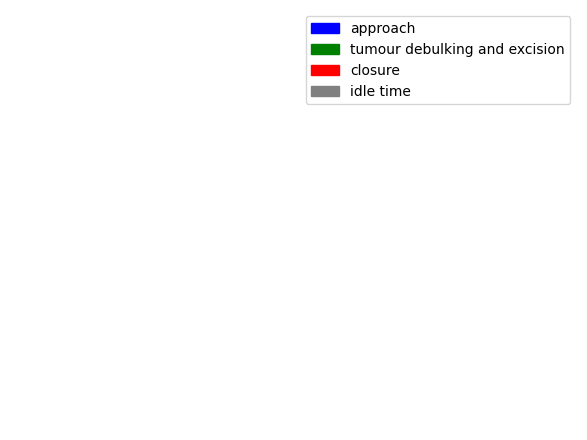

In [156]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Create patches
blue_patch = mpatches.Patch(color='blue', label='approach')
green_patch = mpatches.Patch(color='green', label='tumour debulking and excision')
red_patch = mpatches.Patch(color='red', label='closure')
# skyblue_patch = mpatches.Patch(color='skyblue', label='dissection superior')
# orange_patch = mpatches.Patch(color='orange', label='dissection lateral')
gray_patch = mpatches.Patch(color='gray', label='idle time')


# Add patches to legend
plt.legend(handles=[blue_patch, green_patch, red_patch, gray_patch])
plt.tight_layout()

# Hide axes
plt.axis('off')
plt.savefig(os.path.join(PATH_FOR_SAVING, f'phases_legend.png'))

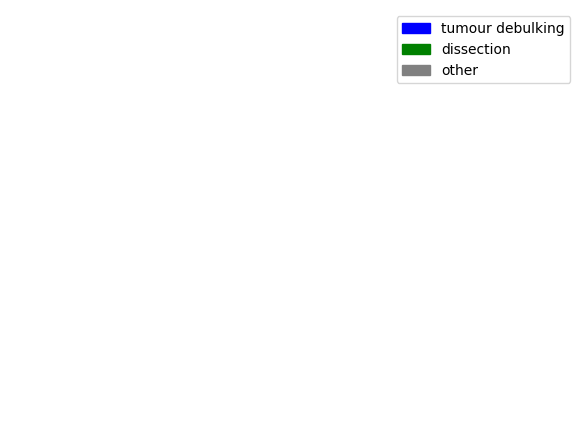

In [157]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Create patches
blue_patch = mpatches.Patch(color='blue', label='tumour debulking')
green_patch = mpatches.Patch(color='green', label='dissection')
# red_patch = mpatches.Patch(color='red', label='closure')
# skyblue_patch = mpatches.Patch(color='skyblue', label='dissection superior')
# orange_patch = mpatches.Patch(color='orange', label='dissection lateral')
gray_patch = mpatches.Patch(color='gray', label='other')


# Add patches to legend
plt.legend(handles=[blue_patch, green_patch, gray_patch])
plt.tight_layout()

# Hide axes
plt.axis('off')
plt.savefig(os.path.join(PATH_FOR_SAVING, f'combined_legend.png'))

### Tensorboard results

In [74]:
input_path = '/Users/dorotheeduvaux 1/UCL CSML/MSc Project/FinalResults/tensorboard_data_withExtraResults.csv'
tensorboard_data_df = pandas.read_csv(input_path)
tensorboard_data_df

,Wall time,Step,Value,Run,Tag
0,1.694160e+09,0,0.709882,original_runs_adj_weights_no_dropout,training acc epoch
1,1.694160e+09,1,0.943458,original_runs_adj_weights_no_dropout,training acc epoch
2,1.694161e+09,2,0.977952,original_runs_adj_weights_no_dropout,training acc epoch
3,1.694162e+09,3,0.991850,original_runs_adj_weights_no_dropout,training acc epoch
4,1.694162e+09,4,0.997163,original_runs_adj_weights_no_dropout,training acc epoch
...,...,...,...,...,...
13178,1.694193e+09,45,0.455730,rLSTM_batch20_intprop_ear_1fp250,validation recall epoch
13179,1.694194e+09,46,0.458651,rLSTM_batch20_intprop_ear_1fp250,validation recall epoch
13180,1.694194e+09,47,0.467018,rLSTM_batch20_intprop_ear_1fp250,validation recall epoch
13181,1.694195e+09,48,0.460339,rLSTM_batch20_intprop_ear_1fp250,validation recall epoch


In [93]:
runs = [
    #'new_network_inv_weights_refl_1fps_250_comb_1',
    #'new_network_inv_weights_refl_1fps_250_phase_fold1'
    #'rLSTM_batch30_intprop_ear_1fp250_combined_fold1',
    'rLSTM_batch30_intprop_ear_1fp250_phase_fold1',
       ]
saving_path = '/Users/dorotheeduvaux 1/UCL CSML/MSc Project'
final_results_folder = 'FinalResults/extraResults'
label = 'phases_lstm' #'new_network' #orig_run_no_dropout'

run_map = {
        'new_network_inv_weights_refl_1fps_250_comb_1': 'combined_steps',
        'new_network_inv_weights_refl_1fps_250_phase_fold1': 'phases',
        'rLSTM_batch30_intprop_ear_1fp250_combined_fold1': 'combined_steps_lstm',
        'rLSTM_batch30_intprop_ear_1fp250_phase_fold1': 'phases_lstm',
    
}
tags = ['training loss epoch ', 'training acc epoch', 'validation loss epoch ', 'validation f1 epoch']
tag_map = {'training loss epoch ': 'Training loss', 
           'training acc epoch': 'Training accuracy',
           'validation loss epoch ': 'Validation loss',
           'validation f1 epoch': 'Validation F1'
          }

tensorboard_data_df['epoch'] = tensorboard_data_df['Step'] + 1
tensorboard_data_df['epoch'] = tensorboard_data_df['epoch'].astype(int)
results_df = tensorboard_data_df[tensorboard_data_df['Run'].isin(runs)] # & tensorboard_data_df['Tag'].isin(tags)]
results_df = results_df.sort_values(by=['Run', 'epoch'])

In [94]:
results_df

,Wall time,Step,Value,Run,Tag,epoch
12189,1.701746e+09,0,0.918626,rLSTM_batch30_intprop_ear_1fp250_phase_fold1,training acc epoch,1
12210,1.701746e+09,0,0.266759,rLSTM_batch30_intprop_ear_1fp250_phase_fold1,training loss epoch,1
12231,1.701746e+09,0,0.830040,rLSTM_batch30_intprop_ear_1fp250_phase_fold1,validation acc epoch,1
12252,1.701746e+09,0,0.302376,rLSTM_batch30_intprop_ear_1fp250_phase_fold1,validation f1 epoch,1
12273,1.701746e+09,0,0.767512,rLSTM_batch30_intprop_ear_1fp250_phase_fold1,validation loss epoch,1
...,...,...,...,...,...,...
12485,1.701184e+09,49,0.845841,rLSTM_batch30_intprop_ear_1fp250_phase_fold1,validation acc epoch,50
12535,1.701184e+09,49,0.728745,rLSTM_batch30_intprop_ear_1fp250_phase_fold1,validation f1 epoch,50
12585,1.701184e+09,49,0.673226,rLSTM_batch30_intprop_ear_1fp250_phase_fold1,validation loss epoch,50
12635,1.701184e+09,49,0.789033,rLSTM_batch30_intprop_ear_1fp250_phase_fold1,validation precision epoch,50


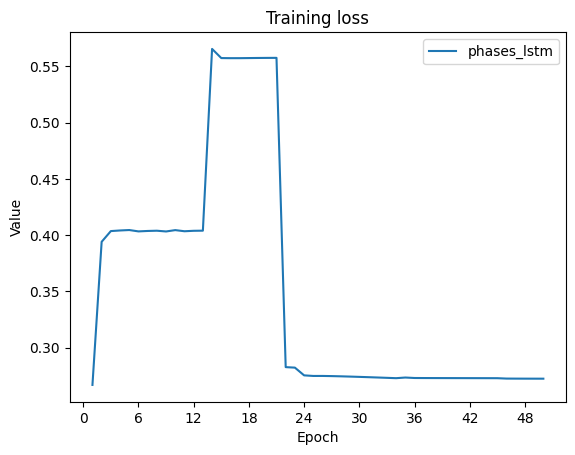

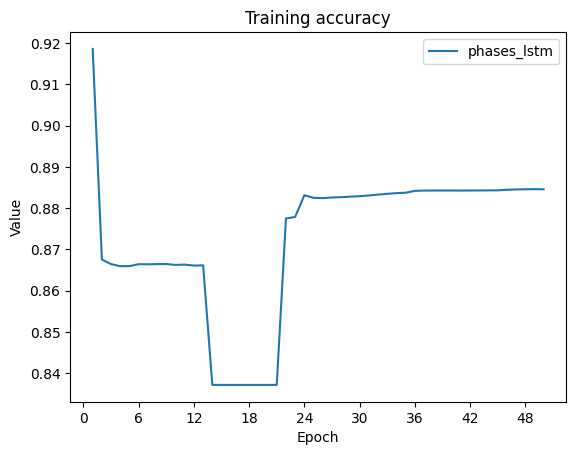

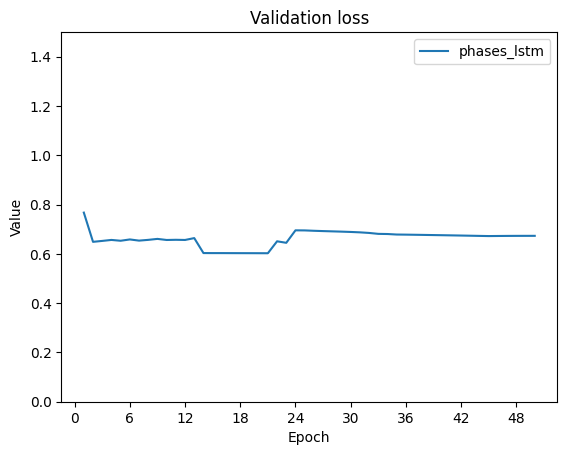

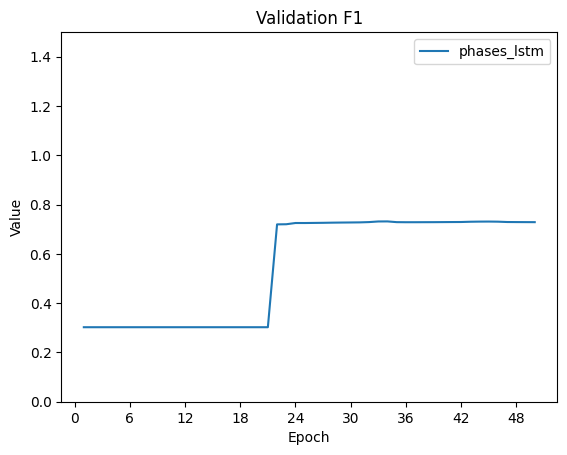

In [95]:
from matplotlib.ticker import MaxNLocator

tag_ylim_max_map = {
          # 'training loss epoch ': 0.65, 
          #  'training acc epoch': 1,
           'validation loss epoch ': 1.5, #3.5, # 4.0,
           'validation f1 epoch': 1.5, #0.55
          }

tag_ylim_min_map = {
           # 'training loss epoch ': 0, 
           # 'training acc epoch': 0.7,
           'validation loss epoch ': 0.0, #1.5, # 1.2,
           'validation f1 epoch': 0.0, #0.1, #0.3
          }

for tag in tags:
    fig, ax = plt.subplots()
    data = results_df[results_df['Tag'] == tag]
    
    runs = data['Run'].unique()   
    # for run in runs: 
    #     run_data = data[data['Run'] == run]
    #     #run_data = run_data[['epoch','Value']]
    #     print(run_data)
    #     run_data = run_data.sort_values(by='epoch', ascending=True)
    #     print(run_data)
    #     print('plotting')
    #     ax.plot(run_data['epoch'], run_data['Value'], label=f'{run_map[run]}')
    for run in runs: 
        run_data = data[data['Run'] == run]
        # Group by 'epoch' and keep only the row with the max 'Wall time' for each group
        idx = run_data.groupby('epoch')['Wall time'].idxmax()  # replace 'Wall time' with your actual column name
        run_data = run_data.loc[idx]
        
        run_data = run_data.sort_values(by='epoch', ascending=True)
        ax.plot(run_data['epoch'], run_data['Value'], label=f'{run_map[run]}')
        
    y_min = tag_ylim_min_map[tag] if tag in tag_ylim_min_map else None
    y_max = tag_ylim_max_map[tag] if tag in tag_ylim_max_map else None
    if y_min is not None and y_max is not None:
        ax.set_ylim(tag_ylim_min_map[tag], tag_ylim_max_map[tag])
    # Set the title dynamically based on the tag
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(f'{tag_map[tag]}')
    plt.legend()

    
    # Display the plot
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    tag = tag.replace(' ', '_')
    plt.savefig(os.path.join(saving_path, final_results_folder, f'{label}_{tag}.png'))
